R environment

In [ ]:
suppressPackageStartupMessages({
    library(reticulate)
    library(ggplot2)
    library(Seurat)
    library(dplyr)
    library(tidyr)
    library(purrr)
    library(tibble)
    library(stringr)
    library(dittoSeq)
    library(future)
    library(data.table)
    plan("multiprocess", workers = 8)
    options(future.globals.maxSize = 1000 * 1024^5)
    options(stringsAsFactors = FALSE)
    set.seed(123)
})

In [ ]:
reference <- readRDS('data/coarse_annotation_GBmap.rds')
reference <- subset(reference, idents = 'TAM')
reference <- subset(reference, subset = c(Leiden == '50' | Leiden == '55' | Leiden == '58'), 
               invert = TRUE) # exclude Mast and DC

In [ ]:
use_condaenv("scarches")

In [ ]:
sc <- import("scanpy")
adata <- sc$read_h5ad("../data/myeloid_SCVI_1000hvg.5had")

In [ ]:
# set embeddings
embedding <- adata$obsm["X_umap"]
rownames(embedding) <- colnames(reference) # obs_names from reference_latent does not have cellIDs (only indexes)
colnames(embedding) <- c("umap_1", "umap_2")
reference[["umap2"]] <- CreateDimReducObject(embedding, key = "umap2_")

# set UMAP models
umap.new.model <- list()
umap.new.model$n_epochs <- 500
umap.new.model$alpha <-1
umap.new.model$method <- "umap"
umap.new.model$negative_sample_rate <- 5
umap.new.model$gamma <- 1
umap.new.model$approx_pow <- 0
umap.new.model$metric$cosine <- list()
umap.new.model$embedding <- reference[["umap2"]]@cell.embeddings
ab_param <- uwot:::find_ab_params(spread = 1, min_dist = 0.3)
umap.new.model$a <- ab_param["a"]
umap.new.model$b <- ab_param["b"]
reference[["umap2"]]@misc$model <- umap.new.model

Warning message:
“No assay specified, setting assay as RNA by default.”


In [ ]:
modules <- read.csv('../data/myeloid_modules_hotspot_1000hvg.csv')
modules

Gene          C            Z         Pval         FDR          Module
1    HBA2          0.69241393   44625.349 0            0            -1    
2    HBB           0.59963601   32857.393 0            0            -1    
3    KCNQ1OT1      0.33463243   28830.068 0            0             8    
4    HBA1          0.64216329   28558.861 0            0            -1    
5    MTRNR2L12     0.27992545   13505.218 0            0             5    
6    RP11-1143G9.4 0.37572261   11948.385 0            0             2    
7    LYPD2         0.22868175    9957.693 0            0            -1    
8    S100A8        0.70249175    9647.513 0            0             2    
9    S100A4        0.68940506    9548.462 0            0             2    
10   IFI27         0.35892363    8917.472 0            0             7    
11   S100A6        0.68808360    7965.467 0            0             2    
12   HSPB1         0.49745810    7737.177 0            0             5    
13   MT-ND3        0.68134464    7211.297 0            0             5    
14   PLCG2         0.38145871    6989.376 0            0             9    
15   APOC1         0.57576279    6859.604 0            0             9    
16   MT-CO3        0.69291592    6786.151 0            0             5    
17   MT-ND2        0.66638379    6569.085 0            0             5    
18   CD52          0.51114135    6527.848 0            0             2    
19   NEAT1         0.51260202    6320.772 0            0             5    
20   JUN           0.60953452    6171.944 0            0             5    
21   TMIGD3        0.50198365    5699.425 0            0             9    
22   CCL18         0.19560547    5298.406 0            0            15    
23   HLA-DPB1      0.78652595    5290.714 0            0             6    
24   APOE          0.68196979    5192.972 0            0             9    
25   LGALS1        0.62291034    5190.661 0            0             2    
26   CCL13         0.21141846    5185.458 0            0            15    
27   HAMP          0.42312986    5047.453 0            0             9    
28   PPBP          0.05974255    4793.273 0            0            -1    
29   LY6E          0.58515779    4694.850 0            0             7    
30   LTB           0.24785707    4023.508 0            0             6    
⋮    ⋮             ⋮            ⋮         ⋮            ⋮            ⋮     
971  DCP1B         7.872947e-03 4.1857290 1.421262e-05 1.463709e-05 NA    
972  TSGA10        4.511048e-03 4.1537113 1.635629e-05 1.682746e-05 NA    
973  GPER1         3.706333e-02 4.1508409 1.656280e-05 1.702241e-05 NA    
974  COQ10A        1.404060e-02 3.9665922 3.645379e-05 3.742689e-05 NA    
975  GEMIN5        6.545842e-03 3.8221104 6.615720e-05 6.785354e-05 NA    
976  TMEM186       8.887740e-03 3.7496055 8.855649e-05 9.073411e-05 NA    
977  ZNF180        6.038596e-03 3.7155225 1.013921e-04 1.037790e-04 NA    
978  HSF2          7.006659e-03 3.6677990 1.223237e-04 1.250754e-04 NA    
979  RHCG          1.395591e-02 3.6621022 1.250770e-04 1.277600e-04 NA    
980  ZNF600        1.051270e-02 3.6575571 1.273153e-04 1.299136e-04 NA    
981  CLDN3         7.505253e-03 3.4315392 3.000832e-04 3.058952e-04 NA    
982  H2AC17        5.082062e-02 3.2443708 5.885520e-04 5.993401e-04 NA    
983  CEMIP         3.063779e-03 3.2110038 6.613608e-04 6.727984e-04 NA    
984  ZNF30         9.744294e-03 2.7469824 3.007318e-03 3.056217e-03 NA    
985  VTRNA1-3      3.391950e-03 2.7284118 3.182005e-03 3.230462e-03 NA    
986  H2AC16        4.603854e-03 2.6927473 3.543298e-03 3.593609e-03 NA    
987  CCDC121       5.478610e-03 2.6753907 3.732110e-03 3.781266e-03 NA    
988  CLEC12B       3.203309e-03 2.3289499 9.930861e-03 1.005148e-02 NA    
989  MROH8         1.425075e-03 2.2837402 1.119340e-02 1.131790e-02 NA    
990  TBX2-AS1      2.691111e-04 2.2508330 1.219806e-02 1.232127e-02 NA    
991  LYG1          6.653955e-03 1.6164792 5.299537e-02 5.347666e-02 NA    
992  CCNA1         4.423472e-0

In [ ]:
x <- modules %>% group_by(Module) %>% top_n(n = 50, wt = Z) %>% arrange(Module)
x_split <- split(x, x$Module)
x_split[['-1']] <- NULL
x_split

Registered S3 method overwritten by 'cli':
  method     from         
  print.boxx spatstat.geom



$`1`
# A tibble: 50 × 6
# Groups:   Module [1]
   Gene         C     Z  Pval   FDR Module
   <chr>    <dbl> <dbl> <dbl> <dbl>  <dbl>
 1 SPARC    0.592 2090.     0     0      1
 2 PLP1     0.516 1789.     0     0      1
 3 FABP7    0.356 1501.     0     0      1
 4 MARCKSL1 0.303 1230.     0     0      1
 5 APOD     0.320 1155.     0     0      1
 6 SEC61G   0.359 1128.     0     0      1
 7 KLF4     0.410 1013.     0     0      1
 8 OLIG1    0.291 1012.     0     0      1
 9 MT3      0.190  950.     0     0      1
10 PTPRZ1   0.305  920.     0     0      1
# … with 40 more rows

$`2`
# A tibble: 50 × 6
# Groups:   Module [1]
   Gene              C      Z  Pval   FDR Module
   <chr>         <dbl>  <dbl> <dbl> <dbl>  <dbl>
 1 RP11-1143G9.4 0.376 11948.     0     0      2
 2 S100A8        0.702  9648.     0     0      2
 3 S100A4        0.689  9548.     0     0      2
 4 S100A6        0.688  7965.     0     0      2
 5 CD52          0.511  6528.     0     0      2
 6 LGALS1        0.623  5191.     0     0      2
 7 S100A9        0.758  3606.     0     0      2
 8 LGALS2        0.403  3582.     0     0      2
 9 S100A10       0.651  3570.     0     0      2
10 PELATON       0.333  3318.     0     0      2
# … with 40 more rows

$`3`
# A tibble: 24 × 6
# Groups:   Module [1]
   Gene        C     Z  Pval   FDR Module
   <chr>   <dbl> <dbl> <dbl> <dbl>  <dbl>
 1 RRM2    0.273 1811.     0     0      3
 2 PCLAF   0.229 1110.     0     0      3
 3 TYMS    0.266  915.     0     0      3
 4 UBE2C   0.211  879.     0     0      3
 5 STMN1   0.322  751.     0     0      3
 6 BIRC5   0.227  638.     0     0      3
 7 CYP19A1 0.206  500.     0     0      3
 8 TOP2A   0.226  496.     0     0      3
 9 CENPF   0.170  394.     0     0      3
10 GTSE1   0.101  338.     0     0      3
# … with 14 more rows

$`4`
# A tibble: 33 × 6
# Groups:   Module [1]
   Gene      C     Z  Pval   FDR Module
   <chr> <dbl> <dbl> <dbl> <dbl>  <dbl>
 1 CD83  0.762  449.     0     0      4
 2 SGK1  0.661  408.     0     0      4
 3 ATF3  0.449  405.     0     0      4
 4 NR4A2 0.425  383.     0     0      4
 5 DUSP1 0.690  360.     0     0      4
 6 NR4A1 0.567  319.     0     0      4
 7 IFI30 0.788  315.     0     0      4
 8 FOS   0.648  298.     0     0      4
 9 ACSL1 0.574  277.     0     0      4
10 BTG2  0.359  265.     0     0      4
# … with 23 more rows

$`5`
# A tibble: 41 × 6
# Groups:   Module [1]
   Gene             C      Z  Pval   FDR Module
   <chr>        <dbl>  <dbl> <dbl> <dbl>  <dbl>
 1 MTRNR2L12    0.280 13505.     0     0      5
 2 HSPB1        0.497  7737.     0     0      5
 3 MT-ND3       0.681  7211.     0     0      5
 4 MT-CO3       0.693  6786.     0     0      5
 5 MT-ND2       0.666  6569.     0     0      5
 6 NEAT1        0.513  6321.     0     0      5
 7 JUN          0.610  6172.     0     0      5
 8 KLF2         0.487  3583.     0     0      5
 9 RP11-160E2.6 0.322  3434.     0     0      5
10 RHOB         0.500  3038.     0     0      5
# … with 31 more rows

$`6`
# A tibble: 38 × 6
# Groups:   Module [1]
   Gene          C     Z  Pval   FDR Module
   <chr>     <dbl> <dbl> <dbl> <dbl>  <dbl>
 1 HLA-DPB1 0.787  5291.     0     0      6
 2 LTB      0.248  4024.     0     0      6
 3 IL22RA2  0.223  3829.     0     0      6
 4 IL32     0.378  3808.     0     0      6
 5 HLA-DRB1 0.770  3681.     0     0      6
 6 CCL17    0.0488 3638.     0     0      6
 7 HLA-DQA1 0.683  3279.     0     0      6
 8 HLA-DQA2 0.567  2850.     0     0      6
 9 CLEC10A  0.413  2625.     0     0      6
10 HLA-DPA1 0.783  1977.     0     0      6
# … with 28 more rows

$`7`
# A tibble: 27 × 6
# Groups:   Module [1]
   Gene       C     Z  Pval   FDR Module
   <chr>  <dbl> <dbl> <dbl> <dbl>  <dbl>
 1 IFI27  0.359 8917.     0     0      7
 2 LY6E   0.585 4695.     0     0      7
 3 IFI6   0.574 3708.     0     0      7
 4 ISG15  0.523 3387.     0     0      7
 5 CXCL11 0.160 2589.     0     0      7
 6 IFITM3 0.538 2252.     0     0      7
 7 IFI44L 0.4

In [ ]:
signatures.list <- list()

for(i in 1:length(x_split)){
  gene.names <- x_split[[i]]$Gene
  signatures.list <- append(signatures.list, list(gene.names))
}

names(signatures.list) <- letters[1:length(x_split)]

signatures.list

$a
 [1] "SPARC"     "PLP1"      "FABP7"     "MARCKSL1"  "APOD"      "SEC61G"   
 [7] "KLF4"      "OLIG1"     "MT3"       "PTPRZ1"    "CLU"       "EGR1"     
[13] "GAP43"     "IGFBP7"    "MIR9-1HG"  "MAP1B"     "FOSB"      "CHI3L1"   
[19] "EGFR"      "IGFBP2"    "MBP"       "NOVA1"     "BCAS1"     "SOX4"     
[25] "COL1A2"    "PMP2"      "PTN"       "CHI3L2"    "GPM6B"     "IGFBP5"   
[31] "SAA1"      "MOBP"      "LINC00844" "GFAP"      "NFIB"      "PDGFRA"   
[37] "TNFAIP3"   "SCG3"      "PRSS23"    "PTGDS"     "ERMN"      "NFKBIZ"   
[43] "VGF"       "SPARCL1"   "BEX3"      "PTX3"      "LTF"       "PAQR6"    
[49] "NKAIN4"    "S1PR3"    

$b
 [1] "RP11-1143G9.4" "S100A8"        "S100A4"        "S100A6"       
 [5] "CD52"          "LGALS1"        "S100A9"        "LGALS2"       
 [9] "S100A10"       "PELATON"       "C15orf48"      "RETN"         
[13] "EMP3"          "EREG"          "RP11-670E13.6" "NRG1"         
[17] "CYP1B1"        "VCAN"          "MIR4435-2HG"   "VEGFA"        
[21] "FCN1"          "LUCAT1"        "SOCS3"         "CTB-61M7.2"   
[25] "IFITM2"        "S100A12"       "AC013461.1"    "CDA"          
[29] "LYZ"           "TIMP1"         "GIMAP7"        "RPS4Y1"       
[33] "CCR2"          "LILRA5"        "CFP"           "CD44"         
[37] "CRIP1"         "FLNA"          "MCEMP1"        "RIPOR2"       
[41] "CLEC4E"        "CD300E"        "RBP7"          "MGST1"        
[45] "DOK2"          "SECTM1"        "CD36"          "CLEC12A"      
[49] "PID1"          "NFE2"         

$c
 [1] "RRM2"    "PCLAF"   "TYMS"    "UBE2C"   "STMN1"   "BIRC5"   "CYP19A1"
 [8] "TOP2A"   "CENPF"   "GTSE1"   "CCNA2"   "TK1"     "CKS1B"   "ASPM"   
[15] "MKI67"   "PTTG1"   "ESCO2"   "CEP55"   "CDK1"    "NUSAP1"  "AURKB"  
[22] "HMMR"    "FAM111B" "ZWINT"  

$d
 [1] "CD83"     "SGK1"     "ATF3"     "NR4A2"    "DUSP1"    "NR4A1"   
 [7] "IFI30"    "FOS"      "ACSL1"    "BTG2"     "ITGAX"    "GPR183"  
[13] "NR4A3"    "CH25H"    "TFRC"     "EGR3"     "EGR2"     "MTRNR2L8"
[19] "ZNF331"   "ST6GAL1"  "TREM1"    "LMNA"     "HBEGF"    "DUSP6"   
[25] "SELPLG"   "PADI2"    "CDKN1A"   "RGS2"     "RGS1"     "P2RY12"  
[31] "PLEK"     "PHLDA1"   "ARID5B"  

$e
 [1] "MTRNR2L12"      "HSPB1"          "MT-ND3"         "MT-CO3"        
 [5] "MT-ND2"         "NEAT1"          "JUN"            "KLF2"          
 [9] "RP11-160E2.6"   "RHOB"           "CH17-373J23.1"  "CTD-3252C9.4"  
[13] "PHACTR1"        "ATP2B1-AS1"     "MT-ND6"         "ZFP36L2"       
[17] "RP5-1171I10.5"  "RP11-386I14.4"  "IER2"           "RP11-796E2.4"  
[21] "RP11-596C23.2"  "RP11-701P16.2"  "GADD45B"        "IER5L"         
[25] "AP000769.1"     "CITED2"         "CTA-29F11.1"    "RP6-91H8.3"    
[29] "RP1-34B20.21"   "RP11-758H9.2"   "RGS16"          "RP11-109G23.3" 
[33] "MID1IP1"        "BASP1"          "MIR222HG"       "RP11-467L13.7" 
[37] "RP13-516M14.4"  "RNU12"          "ZNF503"         "RP11-1017G21.5"
[41] "ILF3-DT"       

$f
 [1] "HLA-DPB1" "LTB"      "IL22RA2"  "IL32"     "HLA-DRB1" "CCL17"   
 [7] "HLA-DQA1" "HLA-DQA2" "CLEC10A"  "HLA-DPA1" "KLRB1"    "GZMB"    
[13] "CD2"      "TRBC2"    "GZMA"     "HLA-DRA"  "ENHO"     "S100B"   
[19] "MMP12"    "TACSTD2"  "PKIB"     "PPP1R14A" "CCL5"     "CD1C"    
[25] "HLA-DRB5" "GPAT3"    "CD1E"     "LSP1"     "JAML"     "IGLC2"   
[31] "NKG7"     "FCER1A"   "CST7"     "AREG"     "IGKC"     "CD1A"    
[37] "HLA-DQB2" "XCL1"    

$g
 [1] "IFI27"   "LY6E"    "IFI6"    "ISG15"   "CXCL11"  "IFITM3"  "IFI44L" 
 [8] "IFIT1"   "CXCL9"   "DEFB1"   "CXCL10"  "IDO1"    "IFIT3"   "TNFSF10"
[15] "MX1"     "CCL2"    "CCL8"    "RSAD2"   "ISG20"   "XAF1"    "MX2"    
[22] "HERC5"   "NEXN"    "GBP1"    "IFIT2"   "CALB2"   "PARP14" 

$h
 [1] "KCNQ1OT1"       "RP11-498P14.5"  "CX3CR1"         "P2RY13"        
 [5] "KCNMB1"         "H2BC8"          "COLEC12"        "GRID2"         
 [9] "RPS6KA5"        "AC006129.2"     "PLD4"           "LL22NC03-2H8.5"
[13] "SLC25A37"       "BCYRN1"         "CACNA1A"        "ADGRG1"        
[17] "SLC43A2"     

In [ ]:
reference <- AddModuleScore(object = reference,
                                       features =signatures.list,
                                       name = names(signatures.list)
                                      )

Warning message:
“The following features are not present in the object: BEX3, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: SECTM1, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: CYP19A1, CEP55, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: MT-ND2, RP5-1171I10.5, RP11-109G23.3, ZNF503, RP11-1017G21.5, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: IL22RA2, MMP12, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: RP11-498P14.5, ADGRG1, GSTM3, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: RP11-597D13.8, RP11-403I13.5, RP11-12G12.7, not searching for symbol synonyms”
Warning message:
“The following features are not present in the objec

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To di

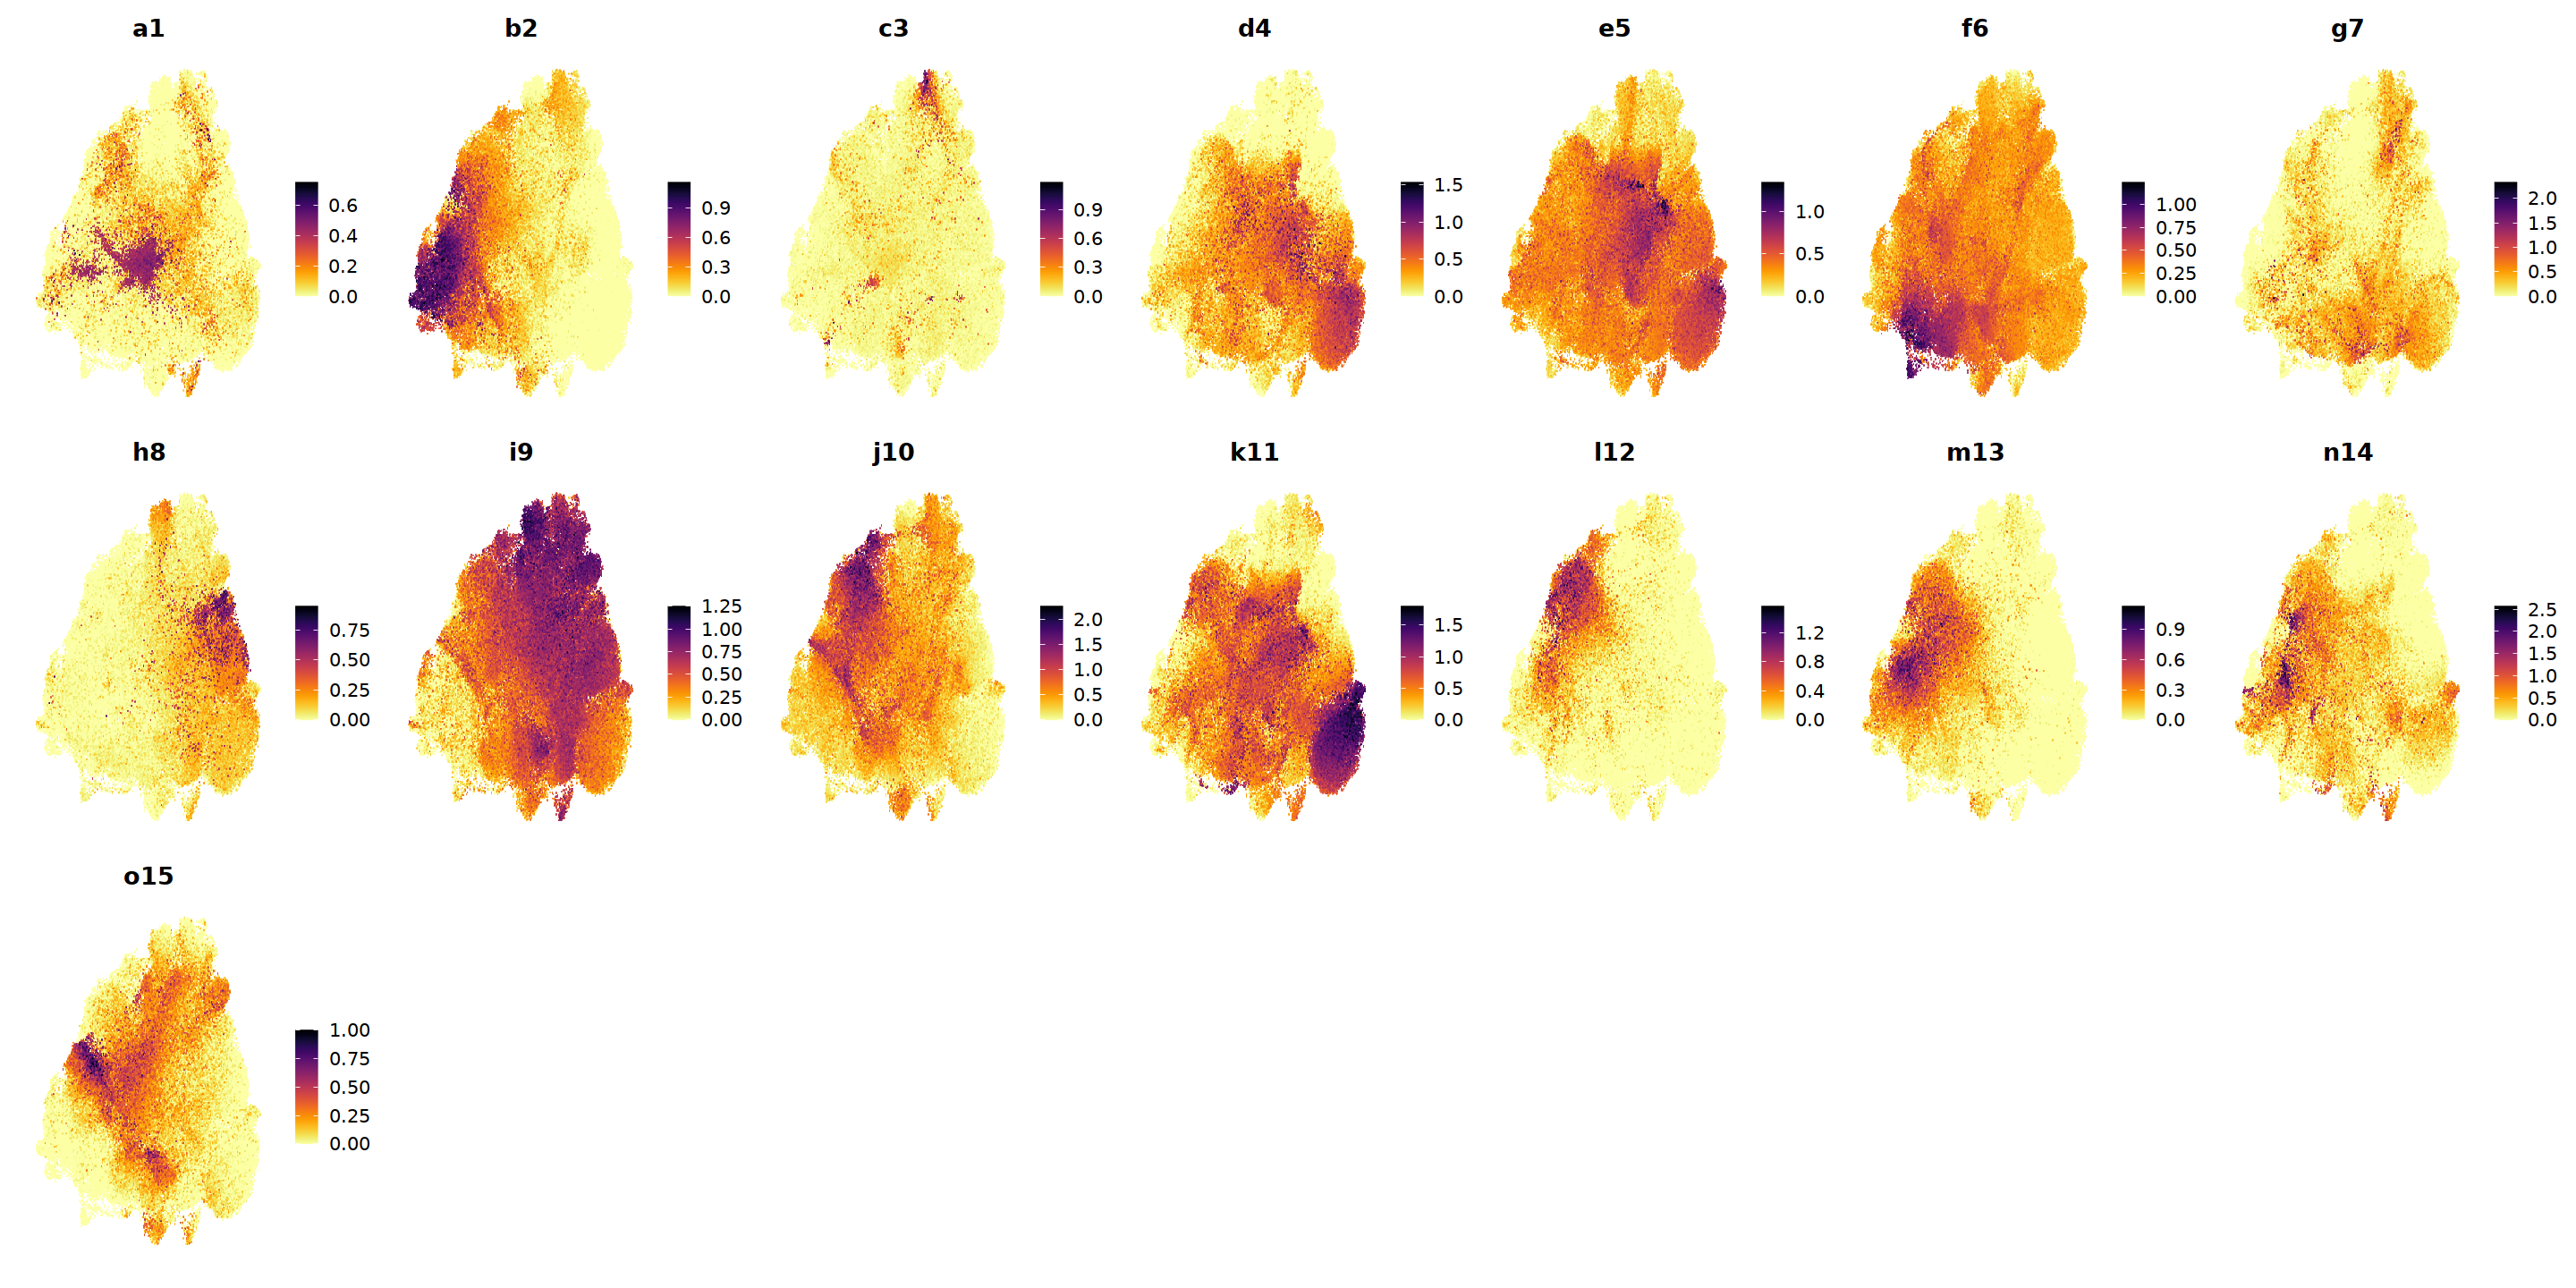

In [ ]:
options(repr.plot.height = 12, repr.plot.width = 24)
p <- FeaturePlot(reference, c('a1','b2','c3','d4','e5','f6','g7','h8','i9','j10','k11','l12','m13','n14', 'o15'), 
                 reduction = 'umap2', order = TRUE,
                 min.cutoff = 0, pt.size = 1, ncol = 7,
                raster = TRUE) & 
  viridis::scale_colour_viridis(option = 'inferno', direction = -1) 
p & NoAxes() 

# In the manuscript, the number of the modules where arranged in order from top to bottom
# The matching modules dispalyed in Figure 2 and Supp Fig 2 are as follows:
# a1 = Module 1 - RNA cont./ Doublets
# b2 = Module 8 - Naive (MES-like)
# c3 = Module 2 - Cell cycle
# d4 = Module 14 - Bona fide MG
# e5 = Module 3 - Stress signature
# f6 = Module 6 - cDC2
# g7 = Module 7 - INF
# h8 = Module Bona fide MG
# i9 = Module - Aging signature
# j10 = Module 10 - MES-like
# k11 = Module 12 - Pro-inflammatory II
# l12 = Module 11 - Hypoxia
# m13 = Module 9 - Tumor supportive
# n14 = Module 14 - Pro-inflammatory I
# o15 = Module 12 - Anti-inflammatory

In [ ]:
ggsave('../figures/TAM_module_scores_inferno.pdf', height = 10.5, width = 25)

For cell annotation, we considered the results from the gene module detection perfomed using Hotspot <br>
and the expression of cell type-specific marker genes identified using the Wilcoxon rank-sum test <br>
by comparing all cells within a specific cluster to all cells outside said cluster. 

In [ ]:
reference <- AddMetaData(reference,
                         adata$obs['leiden'] %>% `rownames<-` (colnames(reference)))

Idents(reference) <- reference@meta.data$`leiden`

reference <- RenameIdents(reference, `0` = "TAM-MG pro-infl",
                    `1` = "TAM-MG APOE/C",
                    `2` = "TAM-BDM hypoxia/MES", 
                    `3` = "TAM-MG activated", 
                    `4` = "TAM-BDM anti-infl", 
                    `5` = "Mono naive", 
                    `6` = "TAM-MG APOE/C", 
                    `7` = "Mono anti-infl", 
                    `8` = "TAM-BDM MCH", 
                    `9` = "TAM-BDM IFI",
                    `10` = "TAM-BDM anti-infl",
                    `11` = "TAM-MG prolif", 
                    `12` = "TAM-BDM anti-infl", 
                    `13` = "TAM-BDM anti-infl", 
                    `14` = "TAM-BDM anti-infl",
                    `15` = "TAM-MG APOE/C",
                    `16` = "TAM-BDM anti-infl", 
                    `17` = "TAM-BDM anti-infl", 
                    `18` = "TAM-BDM IFI", 
                    `19` = "TAM-MG activated",
                    `20` = "TAM-MG APOE/C", 
                    `21` = "Mono hypoxia", 
                    `22` = "TAM-MG APOE/C", 
                    `23` = "cDC2",
                    `24` = "TAM-MG pro-infl", 
                    `25` = "TAM-BDM anti-infl", 
                    `26` = "TAM-BDM anti-infl", 
                    `27` = "TAM-MG pro-infl", 
                    `28` = "TAM-BDM anti-infl",
                    `29` = "TAM-BDM MCH"
                        )

options(repr.plot.height = 10, repr.plot.width = 10)
dittoDimPlot(reference, 
             reduction.use = "umap2", var = "ident", 
             do.label = TRUE, labels.size = 3, size = 0.5)

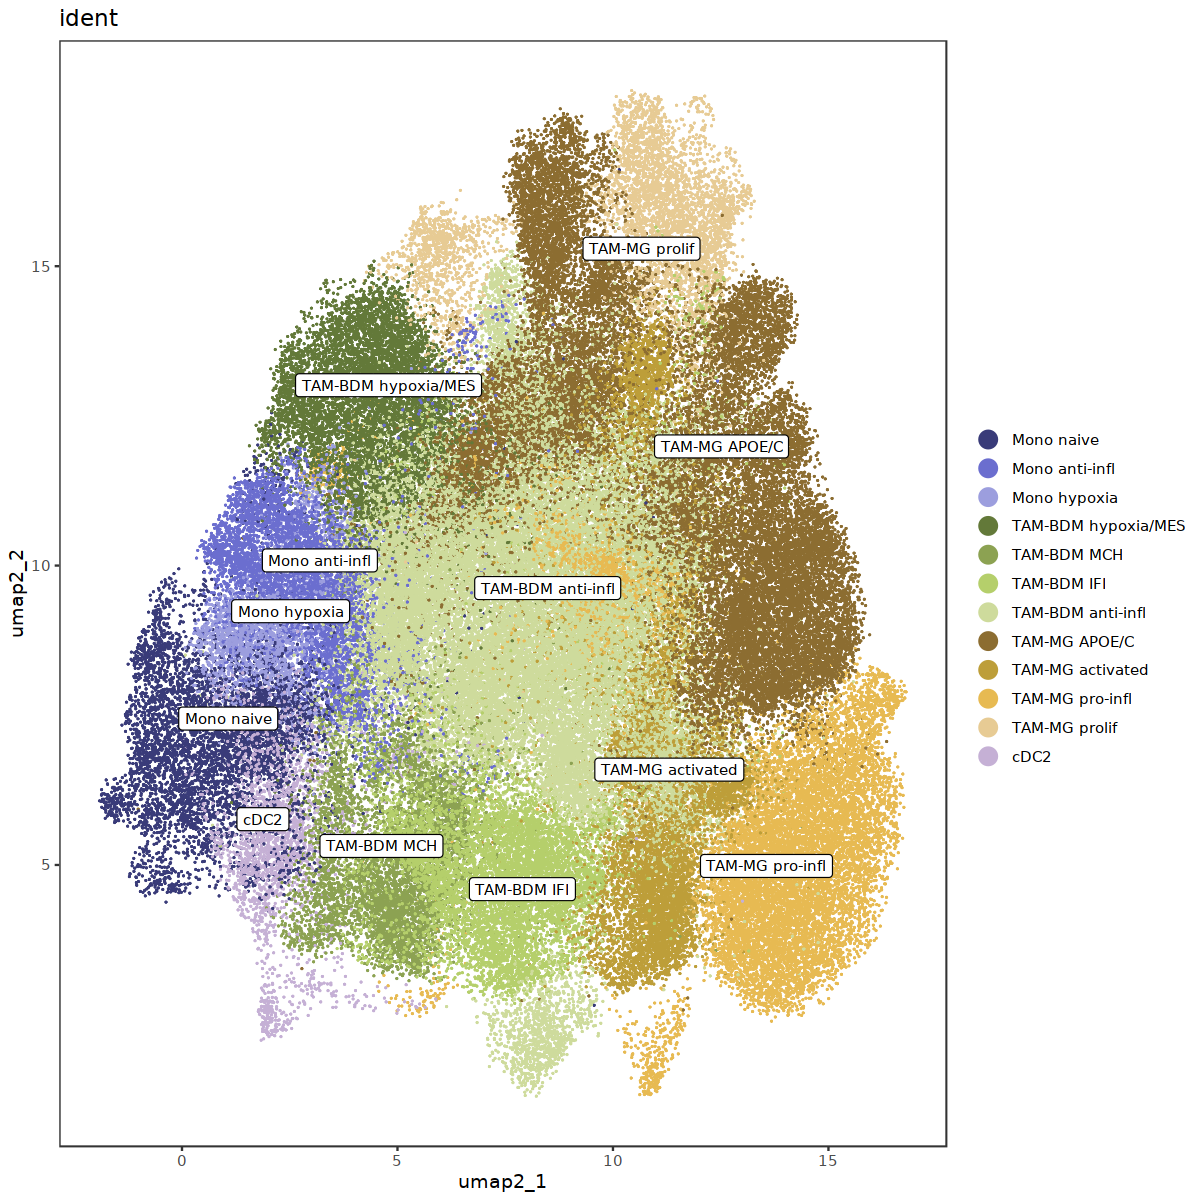

In [ ]:
reference@active.ident <- factor(x = reference@active.ident, 
                                   levels = c('Mono naive','Mono anti-infl','Mono hypoxia',
     'TAM-BDM hypoxia/MES','TAM-BDM MCH','TAM-BDM IFI','TAM-BDM anti-infl',
     'TAM-MG APOE/C', 'TAM-MG activated','TAM-MG pro-infl','TAM-MG prolif',
     'cDC2'))

options(repr.plot.height = 10, repr.plot.width = 10)
dittoDimPlot(reference, 
             reduction.use = "umap2", var = "ident", 
             color.panel = c('#393b79','#6b6ecf', '#9c9ede', #mono
                    '#637939','#8ca252', '#b5cf6b','#cedb9c', #BDM
                    '#8c6d31','#bd9e39', '#e7ba52','#e7cb94', #MG
                    '#c5b0d5'
                            ),
             do.raster = TRUE,
             do.label = TRUE, labels.size = 3, size = 0.5)

In [ ]:
ggsave('../figures/subclustering_TAMs.pdf', width = 8)

Saving 8 x 6.67 in image



In [ ]:
saveRDS(Idents(reference), 'data/TAMs_detailed_cellstates.rds')